In [24]:
import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pickle 


In [25]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [26]:
def extract_features(img):
   
    img = cv2.resize(img,(32,32))
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [27]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1000:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.015 * peri, True)
            if area > max_area and len(approx) == 4 :
                biggest = approx
                max_area = area
    return biggest

In [28]:
# from skimage.color import rgb2gray
def find_sudoku_grid(img):
    # Read the image
    img = cv2.resize(img,(560,420))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and help edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # cv2.imshow("11o",blurred)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    # cv2.imshow("",edges)
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    grid =biggest_contour(contours)  
    # Draw the contours on the original image
    cv2.drawContours(img, [grid], -1, (0, 255, 0), 2)

    # Display the result
    return grid,img


In [29]:
def wrap_grid(img,grid):

    img = cv2.resize(img,(560,420))
    
    points = grid.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    modified_array = np.delete(points, [np.argmin(points_sum),np.argmax(points_sum)], axis=0)
    points_diff = np.diff(modified_array, axis=1)
    input_points[1] = modified_array[np.argmin(points_diff)]
    input_points[2] = modified_array[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    max_width = max(int(bottom_width), int(top_width))
    max_height = max(int(right_height), int(left_height))

    # Desired points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    # print(points,input_points,converted_points)
    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(img, matrix, (max_width, max_height))

  
    return img_output,max_width,max_height

In [30]:

def cells_extraction(width,height):
    cells = np.zeros((9, 9, 2),dtype=int)
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            cells[i,j,0] =width*i//9
            cells[i,j,1] =height*j//9
    return cells



In [37]:
img= io.imread('./samples/lol.jpg')
grid,img1=find_sudoku_grid(img)
output_image,width,height=wrap_grid(img,grid)
output_image=cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
cells=cells_extraction(width,height)

temp=output_image.copy()
out= temp[
    cells[3,0,1]:cells[3,0, 1] + height // 9,
    cells[3,0,0]:cells[3,0, 0] + width // 9
]



edges = cv2.Canny(output_image, 50, 150)


# show_images([img,img1,output_image,out])

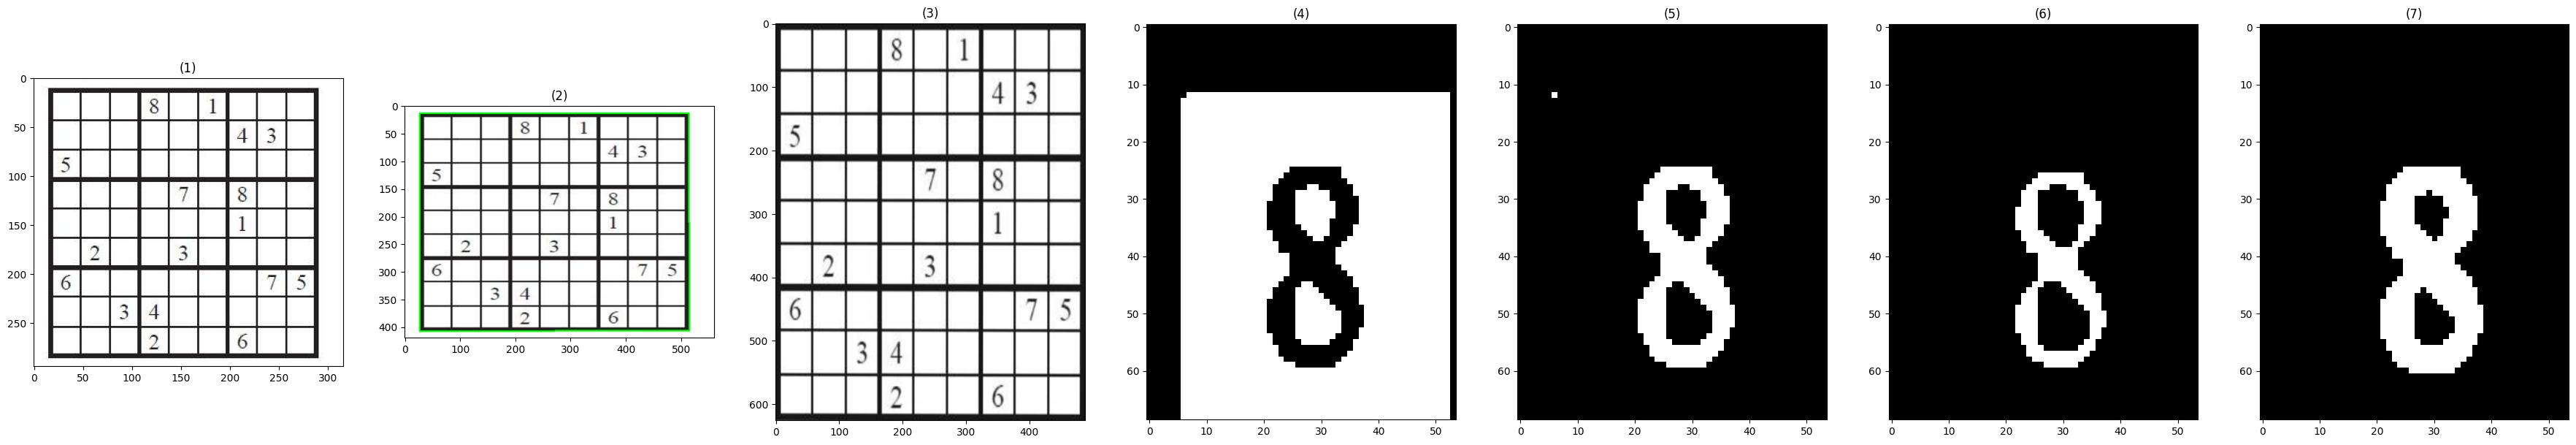

In [38]:

out=np.where(out>200,1,0)
final=out.copy()


for i in range(out.shape[0]):
    if np.sum(out[i,:])== 0:
        final[i,:]=1

for j in range(out.shape[1]):
    if np.sum(out[:,j])== 0:
        final[:,j]=1



final=255-final
# Creating kernel 
kernel = np.ones((2, 2)) 
  
# Using cv2.erode() method  
out_final = cv2.erode(final.astype(np.uint8), kernel)  
# Creating kernel 
kernel2 = np.ones((3, 3)) 
out_final2 = cv2.dilate(out_final.astype(np.uint8), kernel2)  


show_images([img,img1,output_image,out,final,out_final,out_final2])


In [44]:

img1= io.imread('test5.jpg')
freatures=extract_features(out_final)
SVM_MODEL = pickle.load(open('model.pkl', 'rb'))

array=SVM_MODEL.predict([freatures])
print(array)

['a']
